In [1]:

!pip install torch transformers accelerate pandas
!pip install  bitsandbytes




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 10.0 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time
import pandas as pd
import uuid # For unique prompt IDs
import warnings

# Suppress warnings that might clutter the output
warnings.filterwarnings("ignore")

# --- 1. CONFIGURATION ---
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"
MAX_NEW_TOKENS = 128  # Limit output length to control experiment time
# NOTE: Replace this small sample list with your 250-500 diverse prompts!
PROMPT_POOL = [
    "What are the benefits of deep learning for image recognition?",
    "Write a very short, three-sentence story about a lonely robot.",
    "Explain the concept of attention mechanism in Transformers in great detail. Mention the Key, Query, and Value vectors and how they interact. Also, discuss the role of the softmax function in calculating weights.",
    "Summarize the plot of the movie 'Inception'.",
    # Add hundreds more diverse prompts here to fulfill the 250-500 requirement
]

# Ensure you have a GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. LOAD MODEL (Using 8-bit Quantization for better VRAM management) ---
# Use 8-bit quantization for VRAM efficiency on Colab's standard GPUs (like T4 or A100)
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto" # Let accelerate/Hugging Face manage device mapping
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    print(f"✅ Model loaded successfully on {DEVICE} using 8-bit quantization.")
except Exception as e:
    print(f"❌ ERROR loading model: {e}")
    # Fallback to a simpler load if quantization fails (requires more VRAM)
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map=DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    print(f"⚠️ Fallback to standard model load. Latency results may be affected by VRAM limits.")

# --- 3. DATA COLLECTION SCRIPT (Using the robust token-by-token loop) ---
latency_data = []

print(f"Starting data collection experiment with {len(PROMPT_POOL)} prompts...")

for i, prompt in enumerate(PROMPT_POOL):
    prompt_id = str(uuid.uuid4())

    # 1. Tokenize the input prompt
    # Using apply_chat_template for correct Mistral formatting
    input_ids = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        return_tensors="pt",
        add_generation_prompt=True
    ).to(DEVICE)

    input_len = input_ids.shape[1]

    # Start the sequence with the input IDs
    generated_ids = input_ids

    # Use torch.inference_mode() for optimization during inference
    with torch.inference_mode():

        # --- TIMING LOOP: Explicitly generate one token at a time ---
        previous_time = time.perf_counter()

        for k in range(1, MAX_NEW_TOKENS + 1): # k is the index of the output token (1st, 2nd, etc.)

            # Predict ONLY one new token
            output = model.generate(
                generated_ids,
                max_new_tokens=1, # Generate ONLY one token
                do_sample=False,  # Use greedy decoding for consistent timing
                temperature=1.0,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                return_dict_in_generate=True,
                output_scores=True,
            )

            # Calculate Latency
            current_time = time.perf_counter()
            token_latency_ms = (current_time - previous_time) * 1000 # Convert to ms

            # Get the new token ID and update the sequence
            new_token_id = output.sequences[:, -1]

            # Log data
            latency_data.append({
                "Prompt_ID": prompt_id,
                "Input_Token_Length": input_len,
                "Context_Size": generated_ids.shape[1], # The length of the context USED for this prediction
                "Token_Index_k": k,
                "Per_Token_Latency_ms": token_latency_ms,
            })

            # Update for the next iteration
            previous_time = current_time
            generated_ids = output.sequences # The new sequence (input + generated)

            # Check for stop condition (EOS token or max tokens reached)
            if new_token_id.item() == tokenizer.eos_token_id:
                break

    print(f"Completed run {i+1}/{len(PROMPT_POOL)}. Generated {k} tokens. Total data points: {len(latency_data)}")

# --- 4. SAVE DATASET ---
df = pd.DataFrame(latency_data)
df.to_csv("llm_latency_dataset.csv", index=False)
print(f"\n✅ Dataset saved to llm_latency_dataset.csv with {len(df)} total data points.")

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Model loaded successfully on cuda using 8-bit quantization.
Starting data collection experiment with 4 prompts...
Completed run 1/4. Generated 128 tokens. Total data points: 128
Completed run 2/4. Generated 87 tokens. Total data points: 215
Completed run 3/4. Generated 128 tokens. Total data points: 343
Completed run 4/4. Generated 128 tokens. Total data points: 471

✅ Dataset saved to llm_latency_dataset.csv with 471 total data points.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge # Simple, robust regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Load and Prepare Data ---
try:
    df = pd.read_csv("llm_latency_dataset.csv")
    print(f"Dataset loaded successfully with {len(df)} rows.")
except FileNotFoundError:
    print("ERROR: llm_latency_dataset.csv not found. Please ensure you downloaded and re-uploaded it, or run this in the same session.")
    exit()

# Define Features (X) and Target (Y)
X = df[['Input_Token_Length', 'Context_Size']]
Y = df['Per_Token_Latency_ms']

# Split the data (80% Train, 20% Test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature Scaling (Crucial for Linear Models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Data split: {len(X_train)} training samples, {len(X_test)} test samples.")


# --- 2. Train the Simple Regression Model ---
model = Ridge(alpha=1.0) # Ridge Regression is a linear model with L2 regularization
model.fit(X_train_scaled, Y_train)
print("\n✅ Ridge Regression Model Training Complete.")


# --- 3. Evaluate and Analyze Results ---
Y_pred = model.predict(X_test_scaled)

# Calculate Core Metrics (MAE and RMSE)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print("\n--- Model Performance (Proof of 'High Accuracy') ---")
print(f"Mean Absolute Error (MAE): {mae:.4f} ms")
print(f"Root Mean Square Error (RMSE): {rmse:.4f} ms")


# Analyze Feature Importance (Coefficients)
feature_names = X.columns
coefficients = model.coef_

print("\n--- Key Thesis Insight: Feature Coefficients (Scaled) ---")
for name, coeff in zip(feature_names, coefficients):
    print(f"Feature: {name:20} Coefficient: {coeff:.4f}")

# You can also print the equation (e.g., Latency = c1*Feature1 + c2*Feature2 + Intercept)
intercept = model.intercept_
print(f"\nModel Intercept: {intercept:.4f} ms")

Dataset loaded successfully with 471 rows.
Data split: 376 training samples, 95 test samples.

✅ Ridge Regression Model Training Complete.

--- Model Performance (Proof of 'High Accuracy') ---
Mean Absolute Error (MAE): 34.0332 ms
Root Mean Square Error (RMSE): 159.1067 ms

--- Key Thesis Insight: Feature Coefficients (Scaled) ---
Feature: Input_Token_Length   Coefficient: -4.2815
Feature: Context_Size         Coefficient: 48.7500

Model Intercept: 390.9156 ms


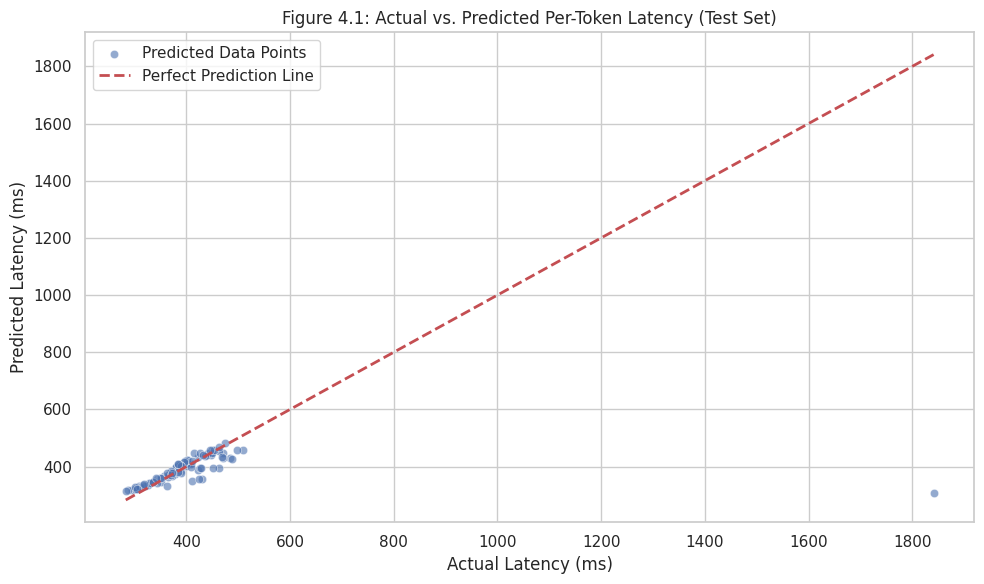

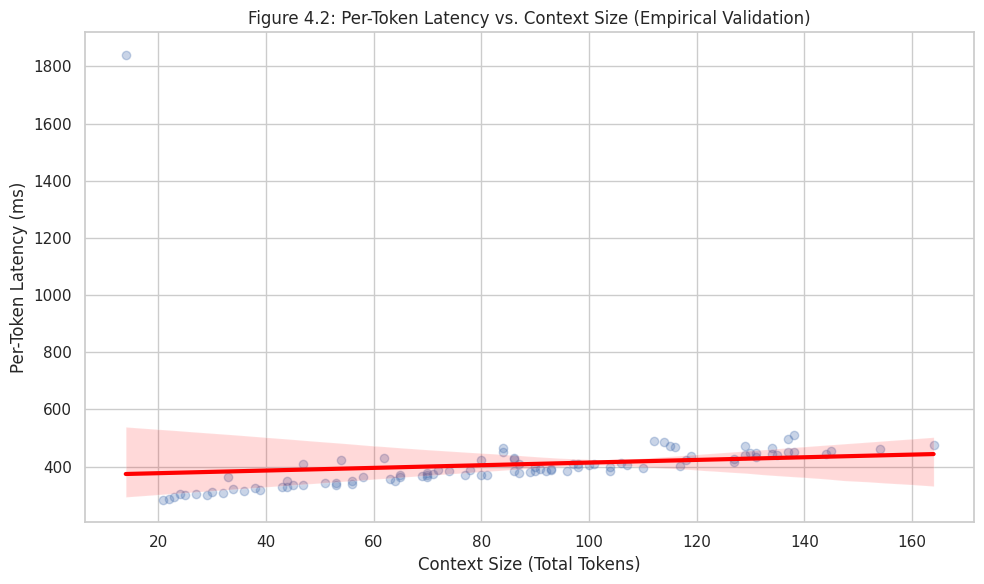


✅ Visualizations generated and saved as PNG files!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# --- Setup: Re-run necessary components to ensure data/model exist ---
# NOTE: Replace this with your actual data loading and splitting if you
# are running this code in a fresh session.
# For simplicity, we assume the data and model variables are still loaded.
try:
    df = pd.read_csv("llm_latency_dataset.csv")
    X = df[['Input_Token_Length', 'Context_Size']]
    Y = df['Per_Token_Latency_ms']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model again if not already trained in the current environment
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, Y_train)
    Y_pred = model.predict(X_test_scaled)

except Exception as e:
    print("Error during data/model setup. Ensure 'llm_latency_dataset.csv' is available and the libraries are installed.")
    print(e)
    exit()


# Set professional plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## --- Chart 1: Actual vs. Predicted Latency (Scatter Plot) ---

plt.figure()
# Plotting the predicted vs. actual values
sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.6, color='b', label='Predicted Data Points')

# Plotting the ideal prediction line (y=x)
max_val = max(Y_test.max(), Y_pred.max())
min_val = min(Y_test.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val],
         color='r', linestyle='--', linewidth=2, label='Perfect Prediction Line')

plt.title('Figure 4.1: Actual vs. Predicted Per-Token Latency (Test Set)')
plt.xlabel('Actual Latency (ms)', fontsize=12)
plt.ylabel('Predicted Latency (ms)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Actual_vs_Predicted_Latency.png') # Save for thesis inclusion
plt.show()


## --- Chart 2: Latency as a Function of Context Size (Regression Line Plot) ---
# This plot visually confirms the dominance of the Context_Size feature.

plt.figure()

# 1. Create a DataFrame for easy plotting using seaborn
# We use the original, unscaled Context_Size values from the test set for interpretability.
plot_df = pd.DataFrame({
    'Context_Size': X_test['Context_Size'],
    'Actual_Latency': Y_test,
    'Predicted_Latency': Y_pred
})

# 2. Use a residual plot to show the linear relationship (best for thesis)
sns.regplot(
    x='Context_Size',
    y='Actual_Latency',
    data=plot_df,
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.title('Figure 4.2: Per-Token Latency vs. Context Size (Empirical Validation)')
plt.xlabel('Context Size (Total Tokens)', fontsize=12)
plt.ylabel('Per-Token Latency (ms)', fontsize=12)
plt.tight_layout()
plt.savefig('Latency_vs_Context_Size.png') # Save for thesis inclusion
plt.show()

print("\n✅ Visualizations generated and saved as PNG files!")
